# PCA Analysis

In [1]:
# import transformers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from torch import cuda
from sentence_transformers import SentenceTransformer, CrossEncoder, util
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from datasets import load_dataset

# 1. Model comparison

Objective: check the significance of difference in top PCA components of different bi-encoder models from SBert.

Models: top 3 on "performance sentence embeddings" on SBert.
- all-mpnet-base-v2
- all-distilroberta-v1
- all-MiniLM-L12-v2

In [2]:
# biencoders
model_mpnet = SentenceTransformer('all-mpnet-base-v2', device='cuda')
model_distil = SentenceTransformer('all-distilroberta-v1', device='cuda')
model_minilm = SentenceTransformer('all-MiniLM-L12-v2', device='cuda')

In [3]:
def get_pcs(model, docs, n_components=20):
    doc_embeddings = model.encode(docs)
    doc_embeddings = StandardScaler().fit_transform(doc_embeddings)
    pca = PCA(n_components=n_components)
    pca.fit(doc_embeddings)
    return pca.components_

def significance_test(arr1, arr2, pc_axis=0):
    if pc_axis==0:
        return [scipy.stats.ttest_ind(arr1[i,:], arr2[i,:]).pvalue for i in range(20)]
    else:
        return [scipy.stats.ttest_ind(arr1[:,i], arr2[:,i]).pvalue for i in range(20)]

## 1.1 COVID

In [4]:
# data
df = pd.read_csv('response_db.csv', encoding='unicode_escape').drop_duplicates(['user_kp','system_kp']).reset_index(drop=True)
queries = df['user_kp'].tolist()
docs = df['system_kp'].tolist()

pcs_mpnet = get_pcs(model_mpnet, docs)
pcs_distil = get_pcs(model_distil, docs)
pcs_minilm = get_pcs(model_minilm, docs)

pv_mpnet_distil = significance_test(pcs_mpnet, pcs_distil)
pv_mpnet_minilm = significance_test(pcs_mpnet, pcs_minilm)
pv_distil_minilm = significance_test(pcs_distil, pcs_minilm)

In [12]:
pcs_distil

array([[ 0.01533511, -0.02706321,  0.0303197 , ..., -0.04782284,
         0.01860295,  0.04515353],
       [ 0.04102901, -0.03736981,  0.0504472 , ...,  0.00095867,
        -0.02980749,  0.04384352],
       [-0.00106945,  0.03093278,  0.0220658 , ..., -0.00153756,
         0.00075489, -0.00716529],
       ...,
       [-0.00456133,  0.01739576,  0.00264274, ..., -0.04080857,
        -0.0576205 , -0.01135791],
       [-0.00646282,  0.01760564, -0.03051886, ..., -0.01413193,
        -0.02268842,  0.01124677],
       [ 0.03181783,  0.03967287,  0.02653894, ..., -0.0159077 ,
         0.02498961, -0.11529076]], dtype=float32)

In [5]:
pcs_mpnet

array([[-6.77504484e-03, -3.40530053e-02, -1.56106232e-02, ...,
        -2.16428190e-02, -6.32597730e-02, -5.48491478e-02],
       [-5.64080924e-02,  6.40984144e-05,  3.81080853e-03, ...,
        -3.85399535e-02,  2.59568393e-02, -4.52464111e-02],
       [ 5.20867994e-03, -4.29361202e-02,  4.04056460e-02, ...,
        -4.32734974e-02, -6.61239168e-03, -5.52224331e-02],
       ...,
       [-6.57229722e-02,  1.83030963e-02, -1.31614842e-02, ...,
        -4.59712707e-02, -5.46937399e-02, -1.09862955e-02],
       [ 3.29291448e-02, -2.62783319e-02,  5.37913330e-02, ...,
        -1.10928267e-02,  2.21846662e-02, -2.23664893e-03],
       [ 4.87755751e-03,  1.84907168e-02,  2.66285408e-02, ...,
        -3.51535827e-02,  2.39926483e-02, -4.99214046e-03]], dtype=float32)

In [9]:
np.mean(pcs_distil - pcs_mpnet)

-2.5468506e-05

In [10]:
np.std(pcs_distil - pcs_mpnet)

0.05083304

In [11]:
# All p-values are large enough to not reject the null hypothesis.
# The model choice does not matter for PCA analyses.
print(pv_mpnet_distil)
print(pv_mpnet_minilm)
print(pv_distil_minilm)

[0.9369904631679166, 0.7257680387902234, 0.9915355692015002, 0.794032837921355, 0.8043209475916491, 0.7757760852906402, 0.980384417231434, 0.7111870623391553, 0.8405846512836396, 0.8168477077820219, 0.8997397512325481, 0.9668346176377536, 0.9806679455986129, 0.8127239262822005, 0.8171735259772803, 0.8686599349612345, 0.8505283177724403, 0.7832375770391147, 0.9985155054118757, 0.9329370012849648]
[0.9986512216132407, 0.8255646316323191, 0.6154325143490207, 0.5987083043174123, 0.9690885953353655, 0.8834858096346746, 0.9794101985976655, 0.6538170325188223, 0.7237411867946559, 0.9128969711999001, 0.9520579482603111, 0.7816297278272876, 0.9836388447371673, 0.9186690271552702, 0.9096385698851972, 0.9709004432982677, 0.9012290347603571, 0.5569384981625133, 0.9905971265240993, 0.749919395290269]
[0.9540878145156675, 0.978013100163617, 0.6101681752807935, 0.7325794693492405, 0.8306272620049115, 0.9563001924620602, 0.9655506768221975, 0.477574944698829, 0.8326736542469784, 0.7847723781872729, 0.

## 1.2 Substance

In [77]:
# data
df = pd.read_csv('Substance_Use_and_Recovery_FAQ.csv')
queries = df['question'].tolist()
docs = df['relevant answer'].tolist()

pcs_mpnet = get_pcs(model_mpnet, docs)
pcs_distil = get_pcs(model_distil, docs)
pcs_minilm = get_pcs(model_minilm, docs)

pv_mpnet_distil = significance_test(pcs_mpnet, pcs_distil)
pv_mpnet_minilm = significance_test(pcs_mpnet, pcs_minilm)
pv_distil_minilm = significance_test(pcs_distil, pcs_minilm)

In [78]:
# All p-values are large enough to not reject the null hypothesis.
# The model choice does not matter for PCA analyses.
print(pv_mpnet_distil)
print(pv_mpnet_minilm)
print(pv_distil_minilm)

[0.9944167672617568, 0.8444469732414226, 0.6001557990766788, 0.9497004808281687, 0.8802335463115841, 0.7871093178443064, 0.8439749493591823, 0.9281202231075372, 0.8567099697359651, 0.9424795538684778, 0.9032074697084329, 0.5902163450156457, 0.547152661377585, 0.8665302652028625, 0.7465890403628914, 0.7376910085750281, 0.8839566694034775, 0.9153363116085202, 0.8962478939088181, 0.8570012119594153]
[0.9286428190535285, 0.7370071137676965, 0.8620899436045542, 0.9277892417265727, 0.9167655044681347, 0.8312671048300979, 0.8261908432514732, 0.7573721693211738, 0.7961558531943909, 0.865016710968687, 0.40821020129547136, 0.9743804483950199, 0.8083542899459676, 0.9828658875426551, 0.6314768552139713, 0.9450047178367911, 0.8485109076725386, 0.5823918126189188, 0.9898429201068609, 0.4912789850811172]
[0.9247125777230959, 0.8437351922209144, 0.8439609176973145, 0.9632840932884992, 0.832868893439331, 0.9823158229522223, 0.9358697934598339, 0.7093672888338542, 0.8960265645468838, 0.8250935092912585,

# 2. OOD

Objective: check the significance of difference in top PCA components of a document base, between in-domain queries and OOD queries.

Document bases:
- COVID
- Substance FAQ

Query sets:
- COVID
- Substance FAQ
- WikiQA

In [79]:
# data
df_covid = pd.read_csv('response_db.csv', encoding='unicode_escape').drop_duplicates(['user_kp','system_kp']).reset_index(drop=True)
df_drugs = pd.read_csv('Substance_Use_and_Recovery_FAQ.csv')
dataset = load_dataset("wiki_qa", split="validation")

# docs
docs_covid = df_covid['system_kp'].tolist()
docs_drugs = df_drugs['relevant answer'].tolist()

# queries
queries_covid = df_covid['user_kp'].tolist()
queries_drugs = df_drugs['question'].tolist()
queries_wikiqa = list(set(dataset['question']))

# query embeddings
query_embeddings_covid = model_mpnet.encode(queries_covid)
query_embeddings_drugs = model_mpnet.encode(queries_drugs)
query_embeddings_wikiqa = model_mpnet.encode(queries_wikiqa)

Using custom data configuration default
Reusing dataset wiki_qa (C:\Users\mikus\.cache\huggingface\datasets\wiki_qa\default\0.1.0\d2d236b5cbdc6fbdab45d168b4d678a002e06ddea3525733a24558150585951c)


## 2.1 COVID

In [80]:
pcs = get_pcs(model_mpnet, docs_covid)
avg_component_importance_covid = np.dot(query_embeddings_covid, pcs.T)
avg_component_importance_drugs = np.dot(query_embeddings_drugs, pcs.T)
avg_component_importance_wikiqa = np.dot(query_embeddings_wikiqa, pcs.T)

pv_drugs_covid = significance_test(avg_component_importance_drugs, avg_component_importance_covid, pc_axis=1)
pv_wikiqa_covid = significance_test(avg_component_importance_wikiqa, avg_component_importance_covid, pc_axis=1)

print(pv_drugs_covid)
print(pv_wikiqa_covid)

[9.571231967544343e-206, 6.579972528837302e-18, 0.018774500716663506, 2.8044145304802305e-25, 1.2639636209463952e-10, 1.7776551944891552e-25, 4.622252327635669e-27, 1.7724098174814244e-07, 0.0003288061498236513, 1.490792160421637e-07, 1.5012936006566718e-06, 7.026367475912774e-16, 2.7423575893195583e-05, 0.012631090170174351, 8.666358346455019e-07, 0.00524830094651863, 4.013128922540761e-05, 0.053754190892597836, 0.5672370790274454, 0.009661431522135831]
[4.0066121707530723e-109, 2.6180885187186997e-16, 2.3519754746350744e-29, 1.6938930892318994e-39, 1.9577873284778268e-50, 0.10679726962479828, 9.814175899250218e-07, 0.09139900240703361, 5.083830270178445e-19, 0.029664794287407828, 2.1773808857018677e-08, 5.415738048496892e-24, 0.6249262117181114, 0.2833325301159165, 0.18408882793005943, 0.12839899999244886, 1.1925870587671484e-09, 5.227727181754987e-17, 1.7004297418956944e-22, 1.9615992429119379e-13]


In [81]:
pv_drugs_covid = [i if i >= 0.01 else 0 for i in pv_drugs_covid]
pv_wikiqa_covid = [i if i >= 0.01 else 0 for i in pv_wikiqa_covid]

equally_important_pc_ids = [i for i in range(20) if pv_drugs_covid[i]==0 and pv_wikiqa_covid[i]==0]
print(equally_important_pc_ids)

[0, 1, 3, 4, 6, 8, 10, 11, 16, 19]


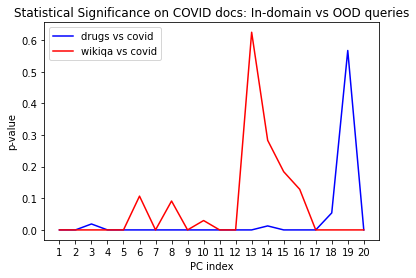

In [82]:
plt.plot(pv_drugs_covid, color='b', label="drugs vs covid")
plt.plot(pv_wikiqa_covid, color='r', label="wikiqa vs covid")
plt.xticks(range(20), range(1,21))
plt.xlabel("PC index")
plt.ylabel("p-value")
plt.title("Statistical Significance on COVID docs: In-domain vs OOD queries")
plt.legend()
plt.show()

## 2.2 Substance

In [83]:
pcs = get_pcs(model_mpnet, docs_drugs)
avg_component_importance_covid = np.dot(query_embeddings_covid, pcs.T)
avg_component_importance_drugs = np.dot(query_embeddings_drugs, pcs.T)
avg_component_importance_wikiqa = np.dot(query_embeddings_wikiqa, pcs.T)

pv_covid_drugs = significance_test(avg_component_importance_covid, avg_component_importance_drugs, pc_axis=1)
pv_wikiqa_drugs = significance_test(avg_component_importance_wikiqa, avg_component_importance_drugs, pc_axis=1)

print(pv_drugs_covid)
print(pv_wikiqa_covid)

[0, 0, 0.018774500716663506, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.012631090170174351, 0, 0, 0, 0.053754190892597836, 0.5672370790274454, 0]
[0, 0, 0, 0, 0, 0.10679726962479828, 0, 0.09139900240703361, 0, 0.029664794287407828, 0, 0, 0.6249262117181114, 0.2833325301159165, 0.18408882793005943, 0.12839899999244886, 0, 0, 0, 0]


In [84]:
pv_covid_drugs = [i if i >= 0.01 else 0 for i in pv_covid_drugs]
pv_wikiqa_drugs = [i if i >= 0.01 else 0 for i in pv_wikiqa_drugs]

equally_important_pc_ids = [i for i in range(20) if pv_covid_drugs[i]==0 and pv_wikiqa_drugs[i]==0]
print(equally_important_pc_ids)

[0, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 18]


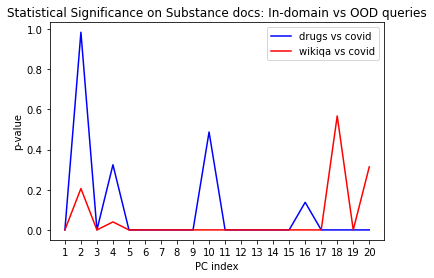

In [85]:
plt.plot(pv_covid_drugs, color='b', label="drugs vs covid")
plt.plot(pv_wikiqa_drugs, color='r', label="wikiqa vs covid")
plt.xticks(range(20), range(1,21))
plt.xlabel("PC index")
plt.ylabel("p-value")
plt.title("Statistical Significance on Substance docs: In-domain vs OOD queries")
plt.legend()
plt.show()

# Draft

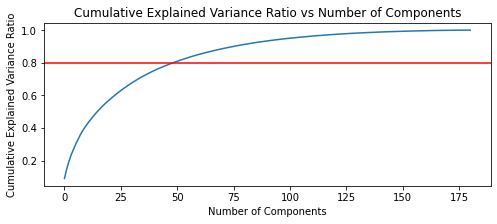

In [44]:
# query_embeddings = bi_encoder.encode(queries)
doc_embeddings = bi_encoder.encode(docs)

scaler = StandardScaler()
doc_embeddings = scaler.fit_transform(doc_embeddings)

pca = PCA()
pca.fit(doc_embeddings)
pca.components_
# transformed_query_embeddings = pca.transform(query_embeddings)
cum_evr = [sum(pca.explained_variance_ratio_[:i+1]) for i in range(len(pca.explained_variance_ratio_))]
plt.figure(figsize=(8,3))
plt.plot(cum_evr)
plt.axhline(y=0.8, color='r')
plt.title("Cumulative Explained Variance Ratio vs Number of Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance Ratio")
plt.show()

In [66]:
pca = PCA(n_components=10)
pca.fit(doc_embeddings)
pca.components_.shape

(10, 768)

In [67]:
query_embeddings.shape

(181, 768)

In [68]:
avg_comp_importance = np.mean(np.dot(query_embeddings, pca.components_.T), axis=0)

In [69]:
avg_comp_importance.argsort()

array([0, 3, 1, 8, 6, 7, 5, 9, 4, 2], dtype=int64)

In [70]:
from datasets import load_dataset

dataset = load_dataset("wiki_qa", split="validation")

Using custom data configuration default
Reusing dataset wiki_qa (C:\Users\mikus\.cache\huggingface\datasets\wiki_qa\default\0.1.0\d2d236b5cbdc6fbdab45d168b4d678a002e06ddea3525733a24558150585951c)


In [71]:
dataset = load_dataset("wiki_qa", split="validation")
irrelevant_queries = list(set(dataset['question']))

In [72]:
ood_query_embeddings = bi_encoder.encode(irrelevant_queries)

In [73]:
avg_comp_importance = np.mean(np.dot(ood_query_embeddings, pca.components_.T), axis=0)

In [74]:
avg_comp_importance.argsort()

array([4, 0, 7, 2, 5, 6, 8, 9, 1, 3], dtype=int64)

In [15]:
def search(query, need_print=True):
    # retrieve
    query_embedding = bi_encoder.encode(query, convert_to_tensor=True).to('cuda')
    hits = util.semantic_search(query_embedding, query_embeddings, top_k=top_k)[0]
    
    # rerank
    cross_inp = [[query, docs[hit['corpus_id']]] for hit in hits]
    cross_scores = cross_encoder.predict(cross_inp)

    # sort by the cross-encoder scores
    for idx in range(len(cross_scores)):
        hits[idx]['cross-score'] = cross_scores[idx]
    
    if need_print:
        # output of retrieval
        print("\n-------------------------\n")
        print("Top-3 Bi-Encoder Retrieval hits")
        hits = sorted(hits, key=lambda x: x['score'], reverse=True)
        for hit in hits[:3]:
            print("\t{:.3f}\t{}".format(hit['score'], docs[hit['corpus_id']].replace("\n", " ")))

        # output of rerank
        print("\n-------------------------\n")
        print("Top-3 Cross-Encoder Reranker hits")
        hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)
        for hit in hits[:3]:
            print("\t{:.3f}\t{}".format(hit['cross-score'], docs[hit['corpus_id']].replace("\n", " ")))
    else:
        hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)
            
    # return top 1
    return [(queries[hit['corpus_id']], docs[hit['corpus_id']]) for hit in hits[:3]]

In [22]:
# CORRECT
search("Is it possible to contract COVID-19 even after being fully vaccinated?")


-------------------------

Top-3 Bi-Encoder Retrieval hits
	0.816	You can still get COVID even after being vaccinated
	0.813	You cannot get COVID from the vaccine
	0.727	Newborns may have some immunity to COVID-19.

-------------------------

Top-3 Cross-Encoder Reranker hits
	0.998	You can still get COVID even after being vaccinated
	0.997	The vaccine will still protect you
	0.997	Not sure yet, make sure to continue following COVID-19 guidelines. 


[('Can I still get COVID even after being vaccinated?',
  'You can still get COVID even after being vaccinated'),
 ('Should people that had COVID get the vaccine?',
  'The vaccine will still protect you'),
 ('Does the vaccine prevent me from giving the virus to others?',
  'Not sure yet, make sure to continue following COVID-19 guidelines. ')]

In [23]:
# CORRECT
search("How do I know if I'm eligible to receive a COVID-19 booster shot?")


-------------------------

Top-3 Bi-Encoder Retrieval hits
	0.749	Verify with your state's health department to determine eligibility 
	0.681	Only get vaccinated by a licensed medical provider
	0.627	You can the vaccine after you have recovered from COVID-19

-------------------------

Top-3 Cross-Encoder Reranker hits
	0.998	Verify with your state's health department to determine eligibility 
	0.997	The chatbot can answer various vaccine questions.
	0.996	The vaccine can be found at a health department or local pharmacy


[('Do I qualify for the vaccine?',
  "Verify with your state's health department to determine eligibility "),
 ('What can you tell me about COVID-19 vaccines?',
  'The chatbot can answer various vaccine questions.'),
 ('Where can I find the vaccine?',
  'The vaccine can be found at a health department or local pharmacy')]

In [24]:
# CORRECT
search("Are there any concerns about vaccine safety for pregnant individuals?")


-------------------------

Top-3 Bi-Encoder Retrieval hits
	0.812	There is no evidence the vaccine will impact pregnancy
	0.793	Children under 5 cannot get the vaccine yet
	0.747	pregnant and breastfeeding women should be offered the vaccine when eligible

-------------------------

Top-3 Cross-Encoder Reranker hits
	0.997	There is no evidence the vaccine will impact pregnancy
	0.994	Safety measures are still important
	0.789	No, the vaccines donEEt cause sterility


[('Does the vaccine impact pregnancy?',
  'There is no evidence the vaccine will impact pregnancy'),
 ('Do I need to continue safety measures after getting the vaccine? ',
  'Safety measures are still important'),
 ('Will the vaccine make me sterile or infertile?',
  'No, the vaccines don\x81E\x80\x81Et cause sterility')]

In [25]:
# INCORRECT
search("Can I take over-the-counter medications to alleviate vaccine side effects?")


-------------------------

Top-3 Bi-Encoder Retrieval hits
	0.741	It is okay to take one pain relievers after vaccination
	0.690	You can get the vaccine even if you take medication
	0.663	Yes, many people don't experience any unpleasant reactions

-------------------------

Top-3 Cross-Encoder Reranker hits
	0.184	No, wait at least 14 days
	0.009	No, you need to receive the same brand
	0.006	Safety measures are still important


[('Can I get other vaccines at the same time?', 'No, wait at least 14 days'),
 ('Can you mix the vaccines?', 'No, you need to receive the same brand'),
 ('Do I need to continue safety measures after getting the vaccine? ',
  'Safety measures are still important')]

In [26]:
# CORRECT
search("Is it true that vaccinated individuals can still transmit the virus to others?")


-------------------------

Top-3 Bi-Encoder Retrieval hits
	0.750	Not sure yet, make sure to continue following COVID-19 guidelines. 
	0.689	The vaccines will help reduce transmission
	0.682	You can still get COVID even after being vaccinated

-------------------------

Top-3 Cross-Encoder Reranker hits
	0.998	Not sure yet, make sure to continue following COVID-19 guidelines. 
	0.998	You can still get COVID even after being vaccinated
	0.996	The vaccine will still protect you


[('Does the vaccine prevent me from giving the virus to others?',
  'Not sure yet, make sure to continue following COVID-19 guidelines. '),
 ('Can I still get COVID even after being vaccinated?',
  'You can still get COVID even after being vaccinated'),
 ('Should people that had COVID get the vaccine?',
  'The vaccine will still protect you')]

In [4]:
def RAG(query):
    qa_pairs = search(query, need_print=False)
    content = '\n'.join([f"Question: {q} Answer: {a}" for q,a in qa_pairs])
    response = chain.invoke({"content": content, "question": query})
    return response, qa_pairs

In [28]:
RAG("Is it possible to contract COVID-19 even after being fully vaccinated?")

'You can still contract COVID-19 even after being fully vaccinated, although the likelihood of severe illness or hospitalization is significantly lower compared to those who are unvaccinated. It is important to continue following COVID-19 guidelines and take necessary precautions to protect yourself and others.'

In [29]:
RAG("How do I know if I'm eligible to receive a COVID-19 booster shot?")

"Verify with your state's health department or consult with your healthcare provider to determine your eligibility for a COVID-19 booster shot."

In [30]:
RAG("Are there any concerns about vaccine safety for pregnant individuals?")

'There are currently no known safety concerns regarding the COVID-19 vaccines for pregnant individuals.'

In [31]:
RAG("Can I take over-the-counter medications to alleviate vaccine side effects?")

'It is recommended to consult with a healthcare professional before taking any medications to alleviate vaccine side effects.'

In [32]:
RAG("Is it true that vaccinated individuals can still transmit the virus to others?")

'Not sure yet, make sure to continue following COVID-19 guidelines.'

In [5]:
logs = pd.read_csv("vira_logs_2023-08-30.csv")

c:\Users\mikus\miniconda3\envs\mrq\lib\site-packages\IPython\core\interactiveshell.py:3398: DtypeWarning: Columns (11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
# get qualified eval rows
temp = logs[(logs['thumbs_up_down']==1) | (logs['intent'].notna())]
temp2 = temp.copy()
temp2['question'] = pd.Series()

temp_intent, temp_question = "", ""
for i,row in temp.iterrows():
    if row['side'] == 'user':
        temp_intent = row['intent']
        temp_question = row['text']
    else:
        temp2.loc[i,'intent'] = temp_intent
        temp2.loc[i,'question'] = temp_question
        
temp = temp2[temp2['side']=='system'].reset_index(drop=True)

C:\Users\mikus\AppData\Local\Temp\ipykernel_4724\645253994.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  temp2['question'] = pd.Series()


In [19]:
temp = logs[logs['intent'].notna()].reset_index()
temp

,index,dialog_id,message_id,side,date,text,language_code,platform,dialog_act,intent,is_feedback,is_concern,is_profanity,thumbs_up_down
0,8,1,1,user,1/19/22,What are the long term side effects of these v...,NaN,whatsapp,concern,Other vaccines have caused long-term health pr...,False,True,FALSE,0
1,11,2,1,user,1/19/22,Are they safe,NaN,whatsapp,concern,The COVID vaccine is not safe,False,True,FALSE,0
2,15,2,5,user,1/19/22,do you know about boosters?,NaN,whatsapp,query,Is the booster shot dangerous?,False,True,FALSE,0
3,19,2,9,user,1/19/22,Is it safe for my baby to get the vaccine?,NaN,whatsapp,FEEDBACK_NEW_KP,Is it safe for my baby to get the vaccine?,True,True,FALSE,0
4,22,4,1,user,1/19/22,How long can the vaccine be?,NaN,whatsapp,concern,How long until I will be protected after takin...,False,True,FALSE,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27230,105436,39527,1,user,8/28/23,Where can I find a vaccine?,en,NaN,query,How can I get the vaccine?,False,True,False,0
27231,105439,39552,1,user,8/29/23,How many people have already gotten the vaccine?,en,NaN,concern,How many people already got the vaccine?,False,True,False,0
27232,105442,39553,1,user,8/29/23,How many people have already gotten the vaccine?,en,NaN,concern,How many people already got the vaccine?,False,True,False,0
27233,105445,39557,1,user,8/29/23,Should people that already had COVID-19 get th...,en,NaN,concern,Should people that had COVID get the vaccine?,False,True,False,0


In [20]:
def evaluate():
    hits = 0
    total = len(temp)
    for _,row in temp.iterrows():
        qa_pairs = search(row['text'], need_print=False)
        qs = [pair[0].strip() for pair in qa_pairs]
        if row['intent'].strip() in qs:
            hits += 1
    print(f"Retrieval Accuracy: {hits/total}")

In [17]:
evaluate()

Retrieval Accuracy: 0.23335931410756042


In [21]:
evaluate()

Retrieval Accuracy: 0.245125757297595
